# Read and convert map datasets to common format

The objective of this notebook is to convert some of our various source datasets into a common and usable format that can later on be easily read and processed.

In [188]:
import numpy as np
import rasterio
import PIL
from PIL import Image
from pathlib import Path
import pickle
import json

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
Image.MAX_IMAGE_PIXELS = 2000000000  # Increase PIL image load limit

In [3]:
data_folder = Path("../data/")
data_raw_folder = data_folder/"raw"
data_processed_folder = data_folder/"processed"

The idea is to have a longitude-latitude grid from at least 80 deg N to 60 deg s and all around the Ecuator, with a resolution of 10 arc-minutes.

In [93]:
longitude_size = 360 * (60/10)
latitude_size = (80 + 60) * (60/10)

img_common_size = (latitude_size, longitude_size)
print(img_common_size)

(840.0, 2160.0)


## Mammal Diversity Map

In [142]:
mammals_raw_folder = data_raw_folder/"mammals"
mammals_processed_folder = data_processed_folder/"mammals"
mammals_raw_file = mammals_raw_folder/"all_mammals.tif"

First, we read the file with `rasterio` and immediately downscale it to the desired resolution.

In [107]:
with rasterio.open(mammals_raw_file) as dataset_reader:
    # Upscale factor for achieving appropriate longitude dimension
    upscale_factor = 1/(dataset_reader.width / longitude_size)
    # Downscale the dataset. Avg scaling to retain integer info
    mammals_array = dataset_reader.read(
        out_shape=(
            dataset_reader.count,
            int(dataset_reader.height * upscale_factor),
            int(dataset_reader.width * upscale_factor)
        ),
        resampling=rasterio.enums.Resampling.average
    ).squeeze()

Then, we cut off the poles and leave the map from 60 degrees S to 80 degrees N.

In [130]:
def cut_poles(array, old_limits, new_limits):
    old_span = old_limits[1] - old_limits[0]
    lower_lim = int(data.shape[0] * (old_limits[1] - new_limits[1]) / old_span)
    upper_lim = int(data.shape[0] - data.shape[0] * (new_limits[0] - old_limits[0]) / old_span)
    return array[lower_lim:upper_lim, :]

In [138]:
mammals_array_processed = cut_poles(mammals_array, (-90, 90), (-60, 80)) 
mammals_array_processed.shape == img_common_size

True

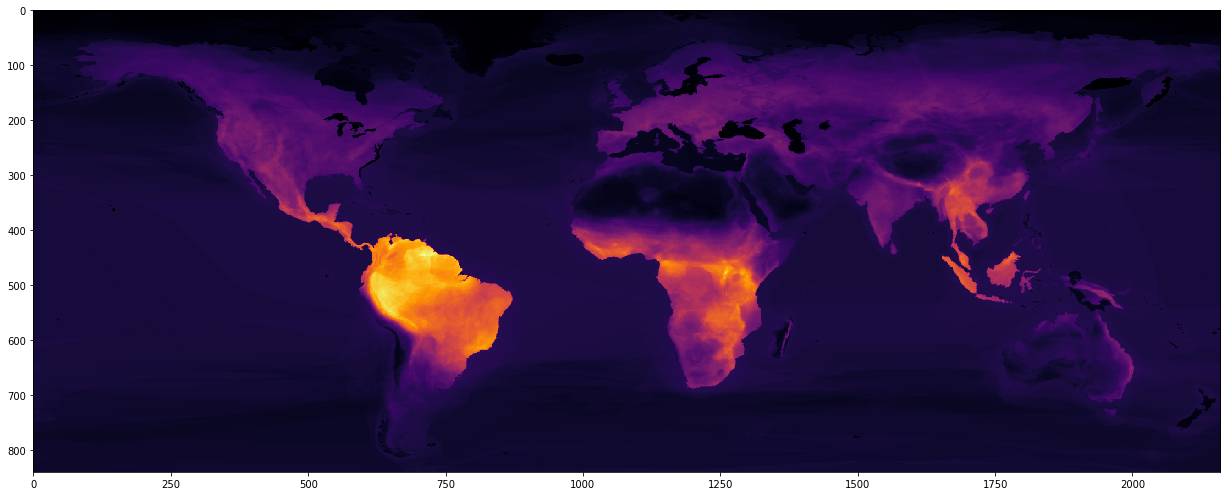

In [139]:
fig, ax = plt.subplots(figsize=(18, 7))
ax.imshow(mammals_array_processed, cmap='inferno')
plt.tight_layout()

In [144]:
with open(mammals_processed_folder/"all_mammals.pickle", "wb") as file:
    pickle.dump(mammals_array_processed, file)

In [190]:
def array_to_coords(array, round_to=3):
    lats = np.arange(80, -60, -(80+60)/840)
    lons = np.arange(-180, 180, 360/2160)
    rows = list()
    rows = [[round(float(lats[i]), round_to), 
             round(float(lons[j]), round_to), 
             round(float(array[i, j]), round_to)]
            for j in range(array.shape[1]) 
            for i in range(array.shape[0])]
    return rows

In [191]:
def array_to_json(array, destination, value_name="value", value_type="real"):
    data = {}
    fields = [
        {"name": "latitude", "format": "", "type": "real"},
        {"name": "longitude", "format": "", "type": "real"},
        {"name": value_name, "format": "", "type": value_type},
    ]
    data["fields"] = fields
    data["rows"] = array_to_coords(array)
    with open(destination, 'w') as file:
        json.dump(data, file)

In [192]:
array_to_json(mammals_array_processed, mammals_processed_folder/"all_mammals.json")